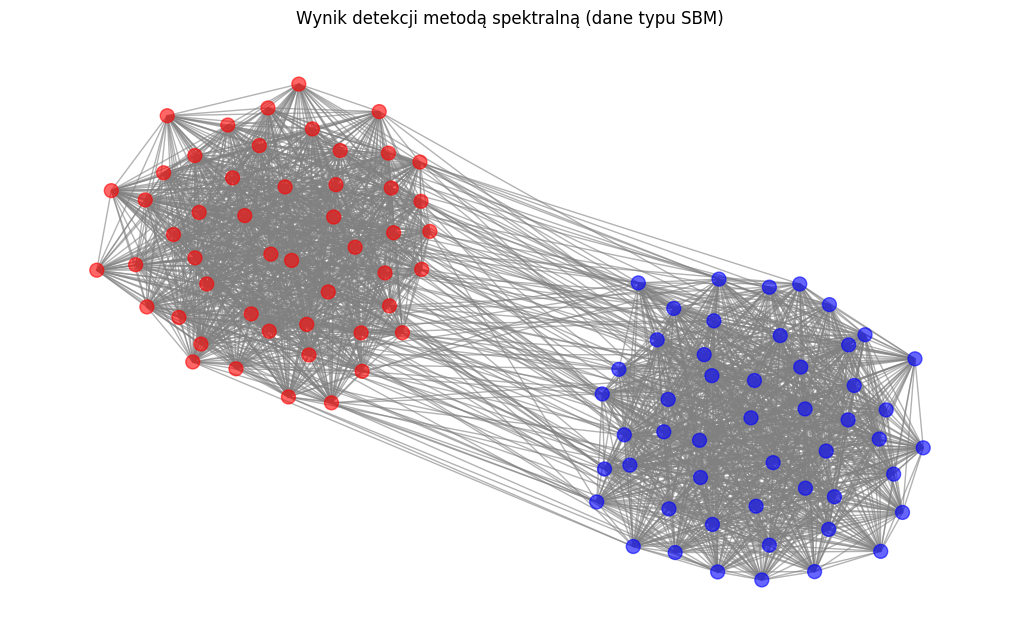

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

def generate_sbm_data():
    """
    Generuje graf zgodny z opisem Stochastic Block Model z wykładu.
    Tworzymy 2 społeczności po 50 węzłów.
    """
    sizes = [50, 50]
    # Prawdopodobieństwa:
    # 0.8 szansa na krawędź wewnątrz grupy (gęsto)
    # 0.05 szansa na krawędź między grupami (rzadko)
    probs = [[0.8, 0.05],
             [0.05, 0.8]]

    G = nx.stochastic_block_model(sizes, probs, seed=42)
    return G

def spectral_clustering_simple(G):
    """
    Prosta implementacja metody spektralnej.
    Opiera się na analizie wektorów własnych macierzy Laplasjanu.
    """
    # 1. Pobieramy macierz sąsiedztwa (A)
    A = nx.to_numpy_array(G)

    # 2. Obliczamy macierz stopni (D) - macierz diagonalna
    degrees = np.sum(A, axis=1)
    D = np.diag(degrees)

    # 3. Obliczamy Laplasjan grafu (L = D - A)
    # z wykladu - szukanie wartości własnych macierzy "pokrewnych" do sąsiedztwa
    L = D - A

    # 4. Rozkład na wartości i wektory własne
    # Szukamy klastrów wartości własnych
    eigenvalues, eigenvectors = LA.eigh(L)

    # 5. Wybór wektora do podziału (Fiedler Vector)
    # Drugi najmniejszy wektor własny niesie informację o podziale grafu.
    # Sortujemy wartości rosnąco, więc indeks 1 to druga najmniejsza.
    fiedler_vector = eigenvectors[:, 1]

    # 6. Podział na klastry
    # Wektory własne definiują podział.
    # W najprostszym wariancie dla 2 grup: węzły z wartością < 0 to jedna grupa, > 0 to druga.
    predicted_communities = [0 if x < 0 else 1 for x in fiedler_vector]

    return predicted_communities

# --- URUCHOMIENIE ---

# 1. Generowanie danych
G = generate_sbm_data()

# 2. Detekcja społeczności naszą metodą
communities = spectral_clustering_simple(G)

# 3. Wizualizacja
pos = nx.spring_layout(G, seed=42)  # Układ grafu
colors = ['red' if c == 0 else 'blue' for c in communities]

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=100, edge_color="gray", alpha=0.6)
plt.title("Wynik detekcji metodą spektralną (dane typu SBM)")
plt.show()

# Dla k - grup

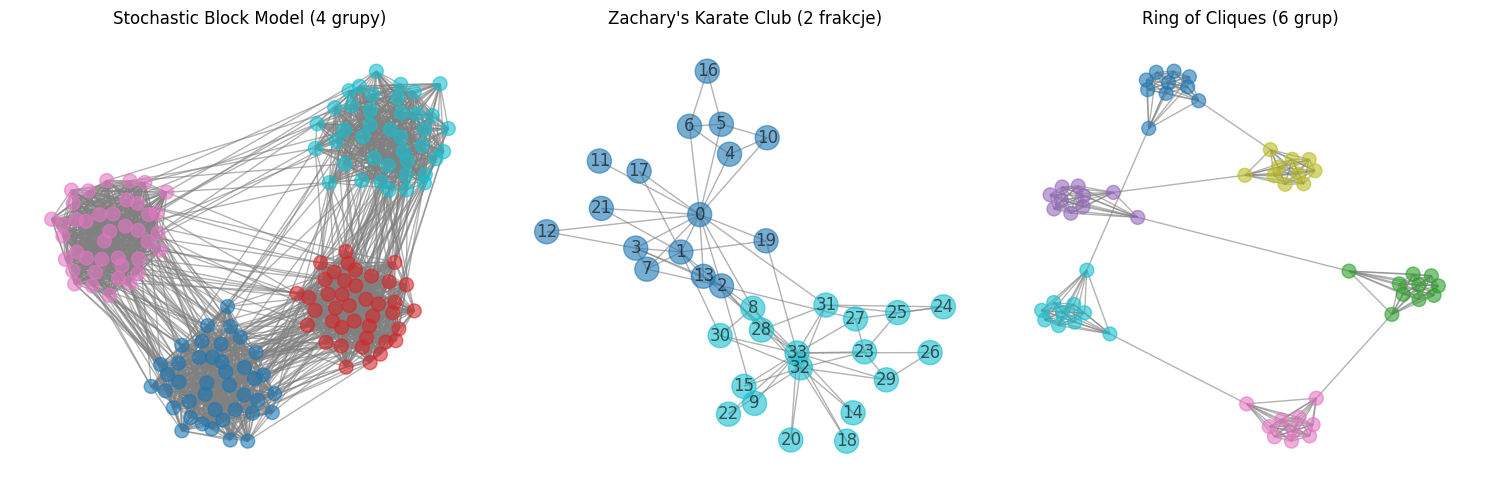

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.cluster import KMeans

def spectral_clustering_k(G, k):
    """
    Ulepszona metoda spektralna dla k klastrów.
    Używa k najmniejszych wektorów własnych Laplasjanu i algorytmu k-means.
    """
    # 1. Macierz Laplasjanu
    A = nx.to_numpy_array(G)
    D = np.diag(np.sum(A, axis=1))
    L = D - A

    # 2. Wartości i wektory własne
    eigenvalues, eigenvectors = LA.eigh(L)

    # 3. Wybór k pierwszych wektorów (pomijając pierwszy trywialny odpowiadający wartości 0)
    # Zazwyczaj bierzemy wektory od indeksu 0 do k (włącznie z zerowym dla stabilności embeddingu)
    # lub od 1 do k. Tutaj weźmiemy kolumny odpowiadające k najmniejszym niezerowym wartościom.
    # Dla Laplasjanu niesymetrycznego (Random Walk) bierze się inne, tu dla L = D-A:
    # Użyjemy k wektorów odpowiadających najmniejszym wartościom własnym.
    embedding = eigenvectors[:, :k]

    # 4. Klasteryzacja wierszy macierzy wektorów własnych (K-Means)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embedding)

    return kmeans.labels_

# --- GENEROWANIE GRAFÓW ---

# 1. Złożony SBM (4 grupy)
def get_complex_sbm():
    sizes = [40, 40, 40, 40]
    # Macierz prawdopodobieństw 4x4
    # Mocne połączenia wewnątrz (0.6 - 0.9), słabe na zewnątrz (0.01 - 0.05)
    probs = [
        [0.80, 0.05, 0.01, 0.01],
        [0.05, 0.70, 0.05, 0.01],
        [0.01, 0.05, 0.80, 0.05],
        [0.01, 0.01, 0.05, 0.60]
    ]
    return nx.stochastic_block_model(sizes, probs, seed=101), 4, "Stochastic Block Model (4 grupy)"

# 2. Klub Karate Zachary'ego (Rzeczywiste dane)
def get_karate_club():
    G = nx.karate_club_graph()
    # Dzielimy się na 2 frakcje (Mr. Hi i Officer) lub 4 mniejsze podgrupy
    return G, 2, "Zachary's Karate Club (2 frakcje)"

# 3. Pierścień Klik (Ring of Cliques)
def get_ring_of_cliques():
    # 6 klik po 10 węzłów, połączonych w pierścień pojedynczymi krawędziami
    G = nx.ring_of_cliques(num_cliques=6, clique_size=10)
    return G, 6, "Ring of Cliques (6 grup)"

# --- WIZUALIZACJA ---

graphs_to_test = [get_complex_sbm(), get_karate_club(), get_ring_of_cliques()]

plt.figure(figsize=(15, 5))

for i, (G, k, title) in enumerate(graphs_to_test):
    # Oblicz społeczności
    labels = spectral_clustering_k(G, k)

    # Rysuj
    plt.subplot(1, 3, i+1)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=100 if i!=1 else 300,
            edge_color='gray', alpha=0.6, with_labels=(i==1))
    plt.title(title)

plt.tight_layout()
plt.savefig('complex_graphs_spectral.png')